# **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
!pip install sklearn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings("ignore")


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-pypi-packag

Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


# **Data Preparation**

In [2]:
df = pd.read_csv('C:/Users/Admin/Desktop/Capstone/Data/EURUSD60 (1).csv', sep='\t')

In [3]:
df

,2008-10-03 20:00,1.38030,1.38050,1.37700,1.37705,18663
0,2008-10-05 21:00,1.36686,1.37040,1.36285,1.36285,4209
1,2008-10-05 22:00,1.36285,1.36765,1.36285,1.36460,15343
2,2008-10-05 23:00,1.36460,1.36750,1.36100,1.36490,16498
3,2008-10-06 00:00,1.36490,1.36700,1.36132,1.36450,27335
4,2008-10-06 01:00,1.36450,1.36510,1.36230,1.36440,24362
...,...,...,...,...,...,...
99994,2024-10-14 02:00,1.09232,1.09268,1.09184,1.09246,6312
99995,2024-10-14 03:00,1.09247,1.09291,1.09235,1.09256,3698
99996,2024-10-14 04:00,1.09255,1.09257,1.09232,1.09236,1800
99997,2024-10-14 05:00,1.09237,1.09263,1.09223,1.09259,4170


In [4]:
new_col = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
df.columns = new_col
df

,Time,Open,High,Low,Close,Volume
0,2008-10-05 21:00,1.36686,1.37040,1.36285,1.36285,4209
1,2008-10-05 22:00,1.36285,1.36765,1.36285,1.36460,15343
2,2008-10-05 23:00,1.36460,1.36750,1.36100,1.36490,16498
3,2008-10-06 00:00,1.36490,1.36700,1.36132,1.36450,27335
4,2008-10-06 01:00,1.36450,1.36510,1.36230,1.36440,24362
...,...,...,...,...,...,...
99994,2024-10-14 02:00,1.09232,1.09268,1.09184,1.09246,6312
99995,2024-10-14 03:00,1.09247,1.09291,1.09235,1.09256,3698
99996,2024-10-14 04:00,1.09255,1.09257,1.09232,1.09236,1800
99997,2024-10-14 05:00,1.09237,1.09263,1.09223,1.09259,4170


In [5]:
df.describe()

,Open,High,Low,Close,Volume
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,1.206504,1.207445,1.205579,1.206504,10783.188142
std,0.122191,0.122392,0.121978,0.122191,11773.847831
min,0.953900,0.955920,0.953570,0.953900,1.000000
25%,1.103905,1.104670,1.103190,1.103910,3799.000000
50%,1.175660,1.176350,1.174970,1.175650,7371.000000
75%,1.313730,1.314850,1.312650,1.313745,13340.000000
max,1.514230,1.514410,1.512830,1.514200,688880.000000


In [6]:
#checking for missing values
df.isnull().sum()

Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [7]:
data = df['Close'].values
data = data.reshape(-1, 1)

**Normalize data**

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

**Prepare training and testing data (80% train, 20% test)**

In [9]:
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


**Create sequences for the LSTM**

In [10]:
def create_sequences(data, time_steps):
    x, y = [], []
    for i in range(len(data) - time_steps):
        x.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(x), np.array(y)

In [11]:
time_steps = 60
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)


**Reshape input to be [samples, time steps, features]**

In [12]:
X_train = X_train.reshape(X_train.shape[0], time_steps, 1)
X_test = X_test.reshape(X_test.shape[0], time_steps, 1)


# **Build LSTM model**

In [13]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))


**Compile the model**

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')


**Train the model**

In [15]:
model.fit(X_train, y_train, batch_size=64, epochs=10)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - loss: 0.0072
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - loss: 3.7370e-04
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - loss: 3.2966e-04
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - loss: 3.2116e-04
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - loss: 3.1891e-04
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - loss: 3.2903e-04
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - loss: 3.1374e-04
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - loss: 3.0618e-04
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - loss: 3.1351e-04
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - loss: 3.1670e-04


**Make predictions**

In [16]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

624/624 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


# **Visualize the predictions vs actual values**

In [17]:
train = df[:train_size]
valid = df[train_size + time_steps:]
valid['Predictions'] = predictions

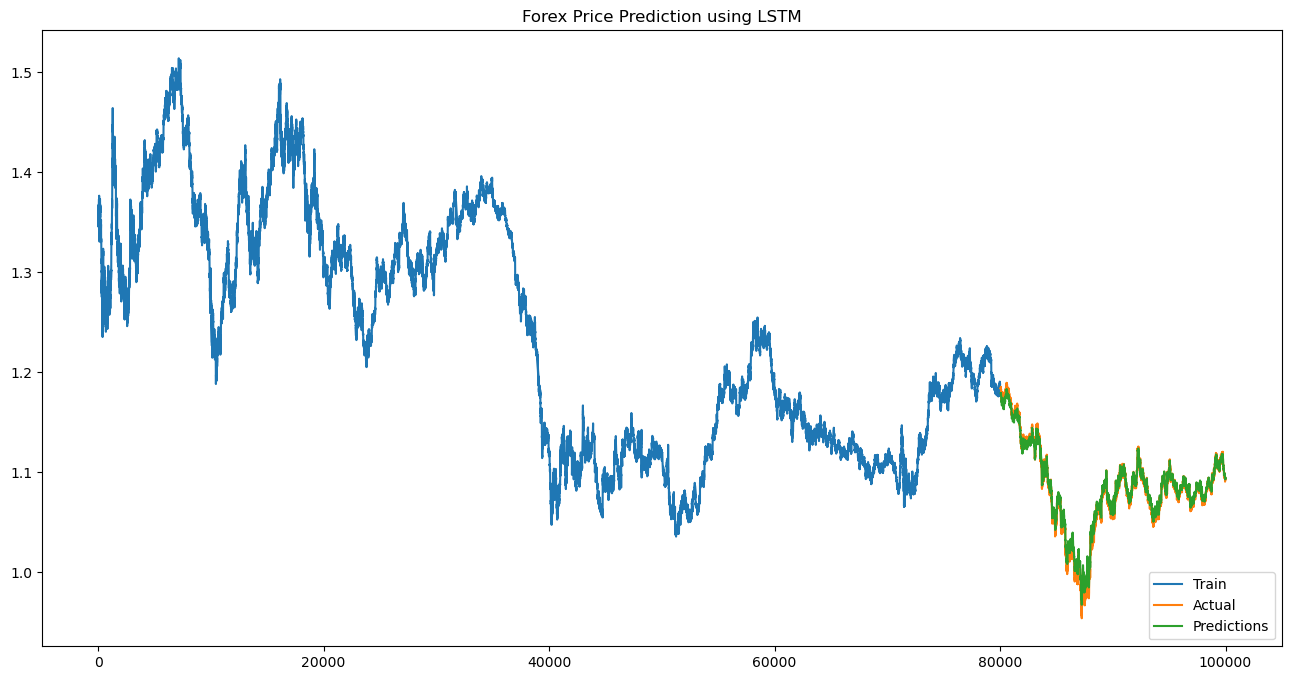

In [18]:
plt.figure(figsize=(16,8))
plt.title('Forex Price Prediction using LSTM')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Actual', 'Predictions'], loc='lower right')
plt.show()

# **Evaluation**

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error
mae = mean_absolute_error(y_test_scaled, predictions)

# Mean Squared Error
mse = mean_squared_error(y_test_scaled, predictions)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# R-squared
r2 = r2_score(y_test_scaled, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 0.003038663870234666
Mean Squared Error (MSE): 1.6283503245200333e-05
Root Mean Squared Error (RMSE): 0.004035282300558454
R-squared (R²): 0.9915418866284579


In [20]:
# Get the last sequence from the test data
last_sequence = test_data[-time_steps:].reshape(1, time_steps, 1)

# Predict the next Forex price
next_prediction_scaled = model.predict(last_sequence)

# Inverse transform the prediction to get the actual price
next_prediction = scaler.inverse_transform(next_prediction_scaled)

print(f"Next predicted Forex price: {next_prediction[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Next predicted Forex price: 1.0934089422225952


In [21]:
def predict_next_steps(model, last_sequence, scaler, num_predictions=5):
    next_predictions = []
    current_sequence = last_sequence

    for _ in range(num_predictions):
        next_prediction_scaled = model.predict(current_sequence)
        next_prediction = scaler.inverse_transform(next_prediction_scaled)
        next_predictions.append(next_prediction[0][0])
        current_sequence = np.append(current_sequence[:, 1:, :], [next_prediction_scaled], axis=1)

    return next_predictions


future_predictions = predict_next_steps(model, last_sequence, scaler, num_predictions=5)

print("Next 5 predicted Forex prices:", future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Next 5 predicted Forex prices: [1.093409, 1.0935564, 1.0937574, 1.0939825, 1.0942122]


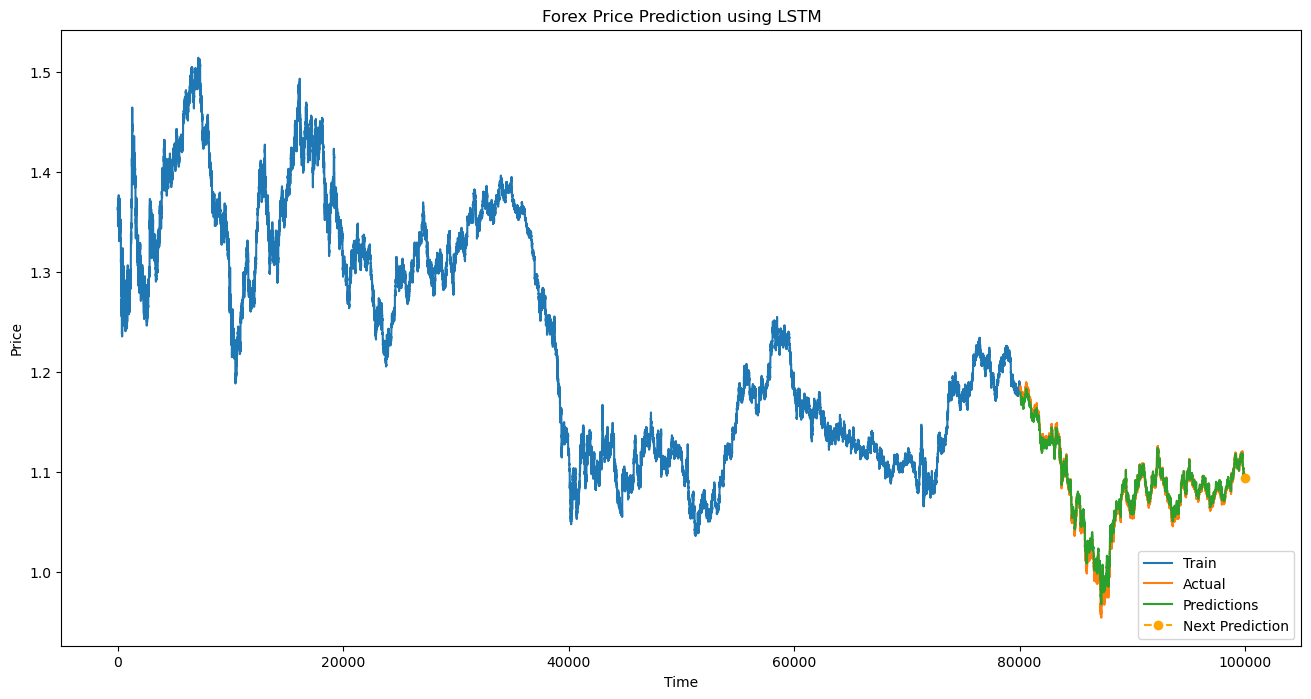

In [22]:

new_row = pd.DataFrame({
    'Close': [None],
    'Predictions': [None],
    'Next Prediction': [next_prediction[0][0]]
}, index=[valid.index[-1] + 1])


valid = pd.concat([valid, new_row])


plt.figure(figsize=(16, 8))
plt.title('Forex Price Prediction using LSTM')
plt.plot(train['Close'], label='Train')
plt.plot(valid['Close'], label='Actual')
plt.plot(valid['Predictions'], label='Predictions')
plt.plot(valid['Next Prediction'], label='Next Prediction', linestyle='--', marker='o', color='orange')


plt.legend(loc='lower right')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()


LSTM Model Optimization in Keras

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler

learning_rate = 0.001
batch_size = 64
epochs = 50
dropout_rate = 0.2
units = 50  # Number of LSTM neurons per layer

# Build the LSTM model
model = Sequential()

# First LSTM layer with Dropout regularization
model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout_rate))

# Second LSTM layer
model.add(LSTM(units=units))
model.add(Dropout(dropout_rate))

# Output layer
model.add(Dense(1))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping and learning rate scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop, reduce_lr])





Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 44ms/step - loss: 0.0071 - val_loss: 2.5873e-05 - learning_rate: 0.0010
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 41ms/step - loss: 0.0011 - val_loss: 4.3197e-05 - learning_rate: 0.0010
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - loss: 6.3474e-04 - val_loss: 6.3648e-05 - learning_rate: 0.0010
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - loss: 3.7616e-04 - val_loss: 8.8921e-05 - learning_rate: 0.0010
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - loss: 3.1532e-04 - val_loss: 2.7527e-05 - learning_rate: 0.0010
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - loss: 2.9939e-04 - val_loss: 2.1052e-04 - learning_rate: 0.0010
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - loss: 2.9471e-04 - val_loss: 4.3801e-05 - learning_rate: 5.0000e-04
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - loss: 2.7854e-04 - val_loss: 5.1180e-05 - learning_rate: 5.0000e-04
Epoch 9/50
1250/1250 ━━━

In [ ]:
# Predictions
y_pred = model.predict(X_test)

624/624 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


In [29]:
# Evaluate the model
mse_test = model.evaluate(X_test, y_test)
print(f"Test MSE: {mse_test}")

624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 8.5148e-06
Test MSE: 8.553451152693015e-06


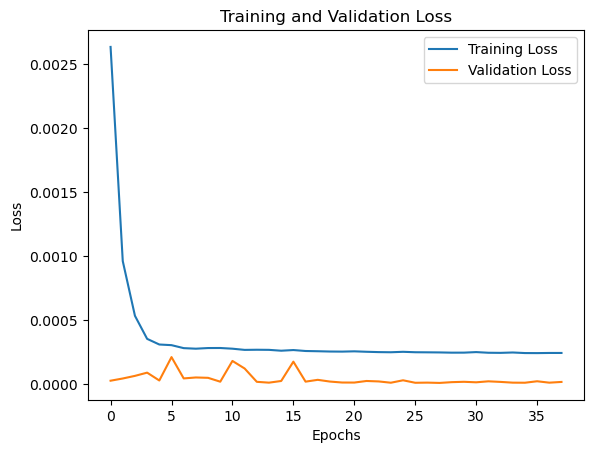

In [30]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()